In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
import time

print("GPUs disponíveis: ", torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPUs disponíveis:  1


In [2]:
# Carregar os dados
df = pd.read_csv("/home/bruno/mestrado/mestrado-projeto-deep-learning/data/df.csv")
df["date"] = pd.to_datetime(df["date"])

# Definir a coluna de data como índice
df.set_index("date", inplace=True)

In [3]:
df = df.drop(columns=["temperature_poa", 'pressure_poa'])

Fazemos o shift de 12 horas, pois na prática não teremos o valor das variáveis em tempo real. Por isso, vamos usar as últimas 12 horas para prever o momento atual.

In [4]:
shifted_columns = df.columns.difference(['water_level_cm_guaiba'])
df[shifted_columns] = df[shifted_columns].shift(12)
df = df.dropna()


In [5]:
# Aplicar scalers
scalers = {col: MinMaxScaler(feature_range=(0, 1)) for col in df.columns}
scaled_data = pd.DataFrame(index=df.index)
for col in df.columns:
    scaled_data[col] = scalers[col].fit_transform(df[[col]])

In [6]:


# Função para criar janelas de tempo
def create_dataset(data, target_column, sequence_length):
    X, Y = [], []
    target_index = data.columns.get_loc(target_column)
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:(i + sequence_length)].values)
        Y.append(data.iloc[i + sequence_length, target_index])
    return np.array(X), np.array(Y)

In [7]:
# Definir a janela de tempo e a variável target
sequence_length = 36
target_column = 'water_level_cm_guaiba'

# Criar o dataset com janelas de tempo
X, Y = create_dataset(scaled_data, target_column, sequence_length)

In [8]:
# Redefinir a forma dos dados para [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

# Dividir os dados em treino (70%), validação (15%) e teste (15%)
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
Y_train, Y_val, Y_test = Y[:train_size], Y[train_size:train_size + val_size], Y[train_size + val_size:]

In [9]:

# Definir o modelo LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim1, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_dim1*2, hidden_dim2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim2*2, output_dim)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.fc(x[:, -1, :])
        return x


In [10]:
# Parâmetros
input_dim = X.shape[2]
hidden_dim1 = 150
hidden_dim2 = 70
output_dim = 1
learning_rate = 1e-3
num_epochs = 200
batch_size = 32
early_stopping_patience = 30

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32).unsqueeze(1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).unsqueeze(1).to(device)

# Criar DataLoader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Inicializar o modelo, função de perda e otimizador
model = LSTMModel(input_dim, hidden_dim1, hidden_dim2, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:

# Treinamento com early stopping
best_loss = float('inf')
patience = 0

for epoch in range(num_epochs):
    model.train()
    for X_batch, Y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f'Epoch {epoch+1}, Loss: {loss.item()}, Val Loss: {val_loss}')

    if val_loss < best_loss:
        best_loss = val_loss
        patience = 0
        best_model_wts = model.state_dict()
    else:
        patience += 1
        if patience >= early_stopping_patience:
            print("Early stopping")
            break

Epoch 1, Loss: 0.008833949454128742, Val Loss: 0.002482287274324335
Epoch 2, Loss: 0.025782734155654907, Val Loss: 0.007626427570357919
Epoch 3, Loss: 0.030251428484916687, Val Loss: 0.008373195811873301
Epoch 4, Loss: 0.018758516758680344, Val Loss: 0.004788979669683613
Epoch 5, Loss: 0.019710350781679153, Val Loss: 0.005843260488472879
Epoch 6, Loss: 0.012779305689036846, Val Loss: 0.0032267067668726667
Epoch 7, Loss: 0.009334570728242397, Val Loss: 0.002402320750115905
Epoch 8, Loss: 0.008971505798399448, Val Loss: 0.0021953176124952733
Epoch 9, Loss: 0.012857513502240181, Val Loss: 0.0036568592884577812
Epoch 10, Loss: 0.0073650917038321495, Val Loss: 0.0018465423592715525
Epoch 11, Loss: 0.008303267881274223, Val Loss: 0.002250387810636312
Epoch 12, Loss: 0.00828396063297987, Val Loss: 0.002281823894008994
Epoch 13, Loss: 0.005590697284787893, Val Loss: 0.0014507043655612507
Epoch 14, Loss: 0.007286082021892071, Val Loss: 0.002056746231392026
Epoch 15, Loss: 0.009671799838542938, 

In [12]:
# Carregar os melhores pesos do modelo
model.load_state_dict(best_model_wts)

# Fazer previsões
model.eval()
with torch.no_grad():
    test_predict = model(X_test_tensor).cpu().numpy()

In [13]:
# Inverter a transformação das previsões e valores reais
y_pred = scalers[target_column].inverse_transform(test_predict)
y_val = scalers[target_column].inverse_transform(Y_val_tensor.cpu().numpy().reshape(-1, 1))
y_train = scalers[target_column].inverse_transform(Y_train_tensor.cpu().numpy().reshape(-1, 1))
y_true = scalers[target_column].inverse_transform(Y_test_tensor.cpu().numpy().reshape(-1, 1))

RMSE: 19.05674934387207


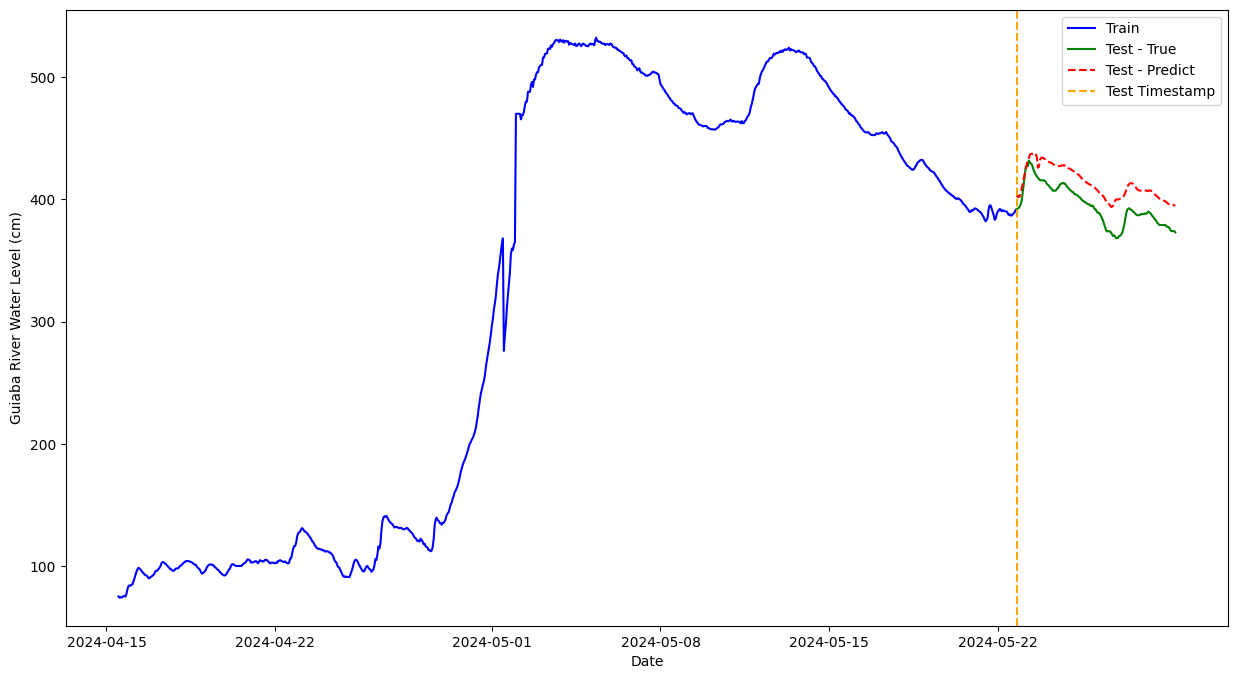

In [14]:
# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')

# Concatenar dados de treino e validação para plotagem
train_val_real = np.concatenate((y_train, y_val))

# Plotar resultados
plt.figure(figsize=(15, 8))
plt.plot(df.index[:len(train_val_real)], train_val_real, label='Train', color='blue')
plt.plot(df.index[len(train_val_real):len(train_val_real) + len(y_true)], y_true, label='Test - True', color='green')
plt.plot(df.index[len(train_val_real):len(train_val_real) + len(y_pred)], y_pred, label='Test - Predict', linestyle='--', color='red')
plt.axvline(x=df.index[len(train_val_real)], color='orange', linestyle='--', label='Test Timestamp')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Guiaba River Water Level (cm)')
# plt.title('Previsão vs Real')
plt.show()

In [ ]:
torch.save(model.state_dict(), f"best_model_12_hours_.pt")

In [15]:
torch.save(model.state_dict(), f"best_model_12_hours_{int(time.time())}.pt")
# # model.load_state_dict(torch.load("best_model.pt"))

In [18]:
def calculate_permutation_importance_for_single_prediction(model, X, y, feature_names, prediction_index):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    
    # Obter previsões de base
    with torch.no_grad():
        baseline_preds = model(X_tensor).cpu().numpy()
    baseline_error = mean_squared_error(y, baseline_preds)

    features = len(feature_names)
    importances = np.zeros(features)

    X_permuted = np.copy(X)
    for feature in range(features):
        original_feature_values = np.copy(X_permuted[prediction_index, :, feature])
        np.random.shuffle(X_permuted[prediction_index, :, feature])
        X_permuted_tensor = torch.tensor(X_permuted, dtype=torch.float32).to(device)
        
        with torch.no_grad():
            permuted_preds = model(X_permuted_tensor).cpu().numpy()
        permuted_error = mean_squared_error(y, permuted_preds)
        importances[feature] = permuted_error - baseline_error
        X_permuted[prediction_index, :, feature] = original_feature_values 

    return importances

In [20]:
model_features = ['wind_speed_poa', 'wind_direction_poa', 'water_level_cm_gravatai', 'hourly_rain_mm_gravatai',
    'water_level_cm_jacui', 'hourly_rain_mm_jacui', 'water_level_cm_sinos',
    'hourly_rain_mm_sinos', 'water_level_cm_taquari',
    'hourly_rain_mm_taquari', 
    'hourly_rain_mm_guaiba']

# Calculando as importâcias

1. Calcula para cada ponto nos dados de teste

In [21]:
test_dates = df.index[len(train_val_real):len(train_val_real) + len(y_true)]

outputs_prediction_importances = []

for index in range(Y_test.shape[0]):
    
    prediction_index = index
    prediction_importances = calculate_permutation_importance_for_single_prediction(model, X_test, Y_test.reshape(-1, 1), model_features, prediction_index)
    outputs_prediction_importances.append(prediction_importances)

2. Normaliza, considerando os seguintes passos:
   - Usamos a relu (np.maximum(0, importance)), pois desconsideramos as importances negativas, pois significa que a remoção delas foi positiva para a previsão, ou seja, elas não tem importância positiva na previsão
   - Depois normaliza, para o vetor de cada previsao tiver soma 1 e podermos interpretar isso como o percentual de importancia em cada previsao

In [22]:
outputs_norm_importances = []
for importance in outputs_prediction_importances:

    relu_importances = np.maximum(0, importance)
    total_importance = np.sum(relu_importances)
    normalized_importances = relu_importances / total_importance
    outputs_norm_importances.append(normalized_importances)

In [23]:
outputs_norm_importances = np.array(outputs_norm_importances)

3. Cria o dataframe, com as importancias, a date e a previsao realizada

In [24]:
importance_columns = [f'importance_{feature}' for feature in model_features]
df_importance = pd.DataFrame(outputs_norm_importances, columns=importance_columns)

df_importance['y_pred'] = y_pred.flatten()

df_importance.index = test_dates

4. Agrega o dataframe por dia e da seguinte forma
   - Para as importances calcula a media
   - Para a previsao temos 3 colunas: media, max e min

In [25]:
aggregated_df = df_importance.resample('12h').agg(
    {**{col: 'mean' for col in importance_columns},
     'y_pred': ['max', 'min', 'mean']}
)

aggregated_df.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in aggregated_df.columns]

5. Obtém as variáveis mais importantes para cada previsão

In [26]:
def get_top_variables_with_values(df, importance_cols, n=4):
    top_vars = df[importance_cols].apply(
        lambda row: [(col, row[col]) for col in row.nlargest(n).index], axis=1
    )
    return top_vars

importance_cols = aggregated_df.columns.drop(['y_pred_max', 'y_pred_min',
       'y_pred_mean'])

# Identificar as 4 variáveis com maior média para cada dia e seus valores
top_variables_with_values = get_top_variables_with_values(aggregated_df, importance_cols)

In [27]:
# date_index = aggregated_df.index.get_loc("2024-05-24 12:00:00")

# prompt_variables = {f"{str(aggregated_df.index[date_index].date())}": {
#         "main_responsable_variables": [{"variable": var, "importance_in_period": val} for var, val in top_variables_with_values.iloc[date_index]],
#         "y_max": aggregated_df.iloc[date_index]["y_pred_max"],
#         "y_min": aggregated_df.iloc[date_index]["y_pred_min"],
#         "y_mean": aggregated_df.iloc[date_index]["y_pred_mean"]
# }}

# prompt_variables

In [18]:
type(test_predict)

numpy.ndarray

6. Adicionando o valor médio ou somado (para os casos de chuva) para cada variável

In [28]:
rain_cols = [col for col in df if "rain" in col]
other_cols = [col for col in df if "rain" not in col]

aggregated_original = df.resample('12h').agg(
    {**{col: 'mean' for col in other_cols},
     **{col: 'sum' for col in rain_cols}     
     }).drop("water_level_cm_guaiba", axis=1)

In [29]:
column_mapping = {
    'importance_wind_speed_poa_mean': 'wind_speed_poa',
    'importance_wind_direction_poa_mean': 'wind_direction_poa',
    'importance_water_level_cm_gravatai_mean': 'water_level_cm_gravatai',
    'importance_hourly_rain_mm_gravatai_mean': 'hourly_rain_mm_gravatai',
    'importance_water_level_cm_jacui_mean': 'water_level_cm_jacui',
    'importance_hourly_rain_mm_jacui_mean': 'hourly_rain_mm_jacui',
    'importance_water_level_cm_sinos_mean': 'water_level_cm_sinos',
    'importance_hourly_rain_mm_sinos_mean': 'hourly_rain_mm_sinos',
    'importance_water_level_cm_taquari_mean': 'water_level_cm_taquari',
    'importance_hourly_rain_mm_taquari_mean': 'hourly_rain_mm_taquari',
    'importance_hourly_rain_mm_guaiba_mean': 'hourly_rain_mm_guaiba'
}

7. Json para o prompt

In [30]:
# Está em metros pq vamos converter pra metros depois
prompt_mapping = {
    'importance_wind_speed_poa_mean': "velocidade do vento em Porto Alegre (m/s)",
    'importance_wind_direction_poa_mean': "direção do vento em Porto Alegre (graus)",
    'importance_water_level_cm_gravatai_mean': "nível de água do Rio Gravataí (m)",
    'importance_hourly_rain_mm_gravatai_mean': "chuva acumulada no Rio Gravataí para o período (mm)",
    'importance_water_level_cm_jacui_mean': "nível de água do Rio Jacuí (m)",
    'importance_hourly_rain_mm_jacui_mean': "chuva acumulada no Rio Jacuí para o período (mm)",
    'importance_water_level_cm_sinos_mean': "nível de água do Rio dos Sinos (m)",
    'importance_hourly_rain_mm_sinos_mean': "chuva acumulada no Rio dos Sinos para o período (mm)",
    'importance_water_level_cm_taquari_mean': "nível de água do Rio Taquari (m)",
    'importance_hourly_rain_mm_taquari_mean': "chuva acumulada no Rio Taquari para o período (mm)",
    'importance_hourly_rain_mm_guaiba_mean': "chuva acumulada no Rio Guaíba para o período (mm)", 
    'y_pred_max': "Nível máximo previsto para o Rio Guaíba no período", 
    'y_pred_min': "Nível mínimo previsto para o Rio Guaíba no período", 
    'y_pred_mean': "Nível médio previsto para o Rio Guaíba no período"
}

In [31]:
aggregated_df["y_pred_max"] = round(aggregated_df["y_pred_max"]/100, 3)
aggregated_df["y_pred_min"] = round(aggregated_df["y_pred_min"]/100, 3)
aggregated_df["y_pred_mean"] = round(aggregated_df["y_pred_mean"]/100, 3)

In [32]:
aggregated_original["water_level_cm_gravatai"] = round(aggregated_original["water_level_cm_gravatai"]/100, 3)
aggregated_original["water_level_cm_jacui"] = round(aggregated_original["water_level_cm_jacui"]/100, 3)
aggregated_original["water_level_cm_sinos"] = round(aggregated_original["water_level_cm_sinos"]/100, 3)
aggregated_original["water_level_cm_taquari"] = round(aggregated_original["water_level_cm_taquari"]/100, 3)

In [33]:
# Função para renomear as colunas usando o prompt_mapping
def rename_variables(variables, mapping):
    return [{"variable": mapping[var], "importance_in_period": imp, "value": val} for var, imp, val in variables]

# Atualizar o dicionário final com a estrutura desejada e renomear as colunas
aggregated_dict = {}
for date, row, top_vars in zip(aggregated_df.index, aggregated_df.itertuples(), top_variables_with_values):
    date_str = str(date.date())
    part = "first part" if date.hour == 0 else "second part"
    key = f"{date_str} {part}"
    
    # Renomear variáveis
    renamed_top_vars = rename_variables([(var, val, aggregated_original.loc[date, column_mapping[var]]) for var, val in top_vars], prompt_mapping)
    
    aggregated_dict[key] = {
        "main_responsable_variables": renamed_top_vars,
        prompt_mapping['y_pred_max']: row.y_pred_max,
        prompt_mapping['y_pred_min']: row.y_pred_min,
        prompt_mapping['y_pred_mean']: row.y_pred_mean
    }

In [34]:
aggregated_dict["2024-05-22 second part"]

{'main_responsable_variables': [{'variable': 'chuva acumulada no Rio dos Sinos para o período (mm)',
   'importance_in_period': 0.776919481463146,
   'value': 0.0},
  {'variable': 'chuva acumulada no Rio Taquari para o período (mm)',
   'importance_in_period': 0.11424260110394505,
   'value': 0.0},
  {'variable': 'nível de água do Rio dos Sinos (m)',
   'importance_in_period': 0.0364803724725274,
   'value': 4.792},
  {'variable': 'direção do vento em Porto Alegre (graus)',
   'importance_in_period': 0.021812038411893803,
   'value': 122.7275}],
 'Nível máximo previsto para o Rio Guaíba no período': 4.09499979019165,
 'Nível mínimo previsto para o Rio Guaíba no período': 3.989000082015991,
 'Nível médio previsto para o Rio Guaíba no período': 4.0329999923706055}

## Prompt

In [35]:
selected_period = "2024-05-22 second part"

In [38]:
PROMPT = f"""
INSTRUCTION: 
You are a journalist, tasked with writing a brief news article (around 12 lines split into 2 paragraphs).

INPUT:
You will receive data in the following format:

dict(
    'main_responsable_variables': [
                                    dict('variable': nome_da_variável,
                                    'importance_in_period': feature_importance (0 to 1),
                                    'value': variable_value_in_period),
                                    ....
                                    dict('variable': nome_da_variável,
                                    'importance_in_period': feature_importance (0 to 1),
                                    'value': variable_value_in_period)],                                                  
    'Nível máximo previsto para o Rio Guaíba no período': water level value in meters,
    'Nível mínimo previsto para o Rio Guaíba no período': water level value in meters,
    'Nível médio previsto para o Rio Guaíba no período': water level value in meters
    )

HOW THIS INFORMATION WAS CALCULATED:
A forecast was made for the water level of the Guaíba River ('Maximum predicted level for the Guaíba River in the period', 'Minimum predicted level for the Guaíba River in the period', and 'Average predicted level for the Guaíba River in the period').
Based on this, I calculated the feature importance of each forecast and returned in 'main_responsable_variables' the 4 most important features for each forecast.

Each item will contain:
 - 'variable': Name of the variable
 - 'importance_in_period': Feature importance (ranging from 0 to 1, like a percentage)
 - 'value': Value of the variable in the period. Note: The scale will match the variable, e.g., m, m/s, mm, etc.

NEWS ARTICLE FORMAT:
You will also receive the timestamp of the news you will report, for example "2020-05-22 second part", which means the forecast made for the second half of May 22, 2020.
From this, you will write a news article in a tone of concern, remembering that you are a journalist.
ALWAYS mention the maximum, average, and minimum predicted levels for the Guaíba River in the period.
ALWAYS mention the factors that contributed the most to this forecast (specifically the 4 main_responsable_variables)
However, NEVER mention the feature importance value (importance_in_period), but you should convey the tone of each variable according to its importance, without mentioning the exact importance.
For the "value", you can mention it when you find it appropriate.

DATE:
You should write about the forecast for the day {selected_period} (write the date in full), here is the data.
{aggregated_dict[selected_period]}

IMPORTANT: Always reply in Brazilian Portuguese."""


In [39]:
PROMPT

'\nINSTRUCTION: \nYou are a journalist, tasked with writing a brief news article (around 12 lines split into 2 paragraphs).\n\nINPUT:\nYou will receive data in the following format:\n\ndict(\n    \'main_responsable_variables\': [\n                                    dict(\'variable\': nome_da_variável,\n                                    \'importance_in_period\': feature_importance (0 to 1),\n                                    \'value\': variable_value_in_period),\n                                    ....\n                                    dict(\'variable\': nome_da_variável,\n                                    \'importance_in_period\': feature_importance (0 to 1),\n                                    \'value\': variable_value_in_period)],                                                  \n    \'Nível máximo previsto para o Rio Guaíba no período\': water level value in meters,\n    \'Nível mínimo previsto para o Rio Guaíba no período\': water level value in meters,\n    \'Nível mé

# Importância média para as previsões

In [95]:
mean_importances = np.mean(outputs_norm_importances, axis=0)

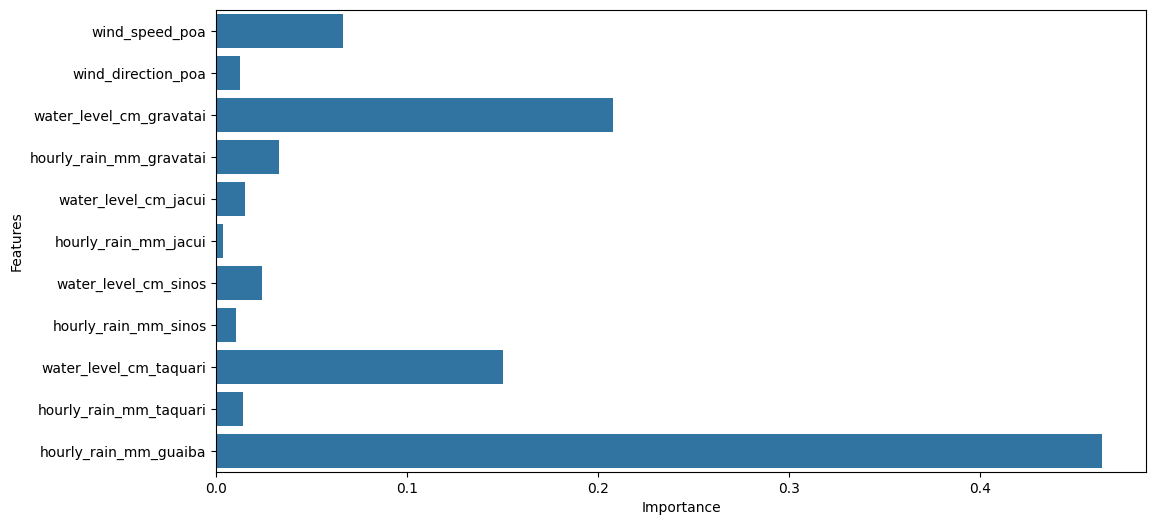

In [96]:
# Plotar importâncias para uma previsão específica
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_importances, y=model_features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()